In [1]:
warning('off','all');
if ~exist('run_once','var')
curdir = pwd;
cd('../..');
startup;
cd(curdir);
run_once = true;
end

In [2]:
%plot -s 600,400

# Simulate ERP data

## Simulate an ERP

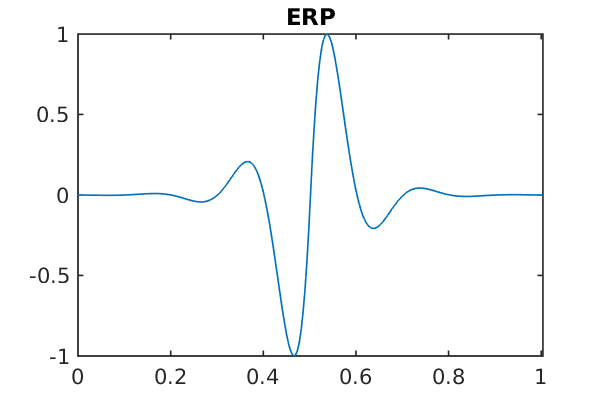

In [3]:
nchannels = 2;
ntrials = 10;
norder = 3;

fs = 250;
nsamples_signal = fs/2;
% generate biosignal
biosignal = BioSignal.muscle('fs',fs,'nsamples',nsamples_signal,'bw',5,'fo',5);
% create erp
erp = [-1*fliplr(biosignal(2:end)) biosignal];
% normalize erp
erp = erp./max(erp);

figure;
nsamples_signal = length(biosignal);
time_start = 0;
time_end = (nsamples_signal*2-1)/fs;
time_axis = linspace(time_start,time_end,nsamples_signal*2-1);
plot(time_axis, erp);
xlim([time_axis(1), time_axis(end)]);
title('ERP');

## Simulate multiple trials

In [4]:
nsamples = length(erp);

% allocate mem for data
x_orig = zeros(nchannels,nsamples,ntrials);
x = zeros(nchannels,nsamples,ntrials);
for i=1:ntrials
    % simulate noise
    sigma = 0.05;
    noise = mvnrnd([0 0], [sigma 0; 0 sigma],nsamples)';
    
    % add erp variability
    H = [2; -5];
    [signal_trial,scale] = BioSignal.rand_scale(erp,1,0.05);
    %fprintf('scale: %f\n',scale);
    [signal_trial,shift] = BioSignal.rand_time_shift(signal_trial,0,15);
    %fprintf('shift: %d\n',shift);
    
    % create the signal
    x_orig(:,:,i) = H*signal_trial + noise;
    
    % normalize variance of each channel to unit variance
    x(:,:,i) = x_orig(:,:,i)./repmat(std(x_orig(:,:,i),0,2),1,nsamples);
end

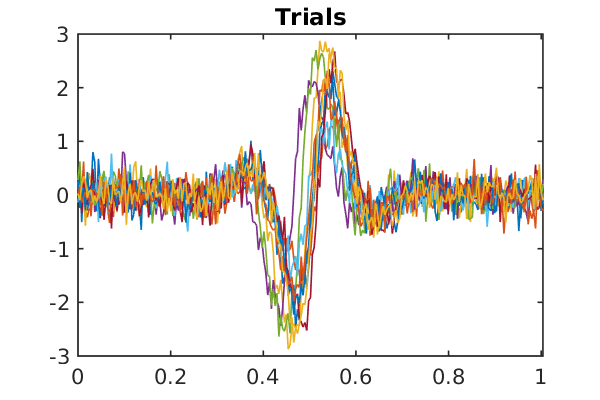

In [5]:
figure;
plot(time_axis,squeeze(x_orig(1,:,:)));
xlim([time_axis(1), time_axis(end)]);
title('Trials');

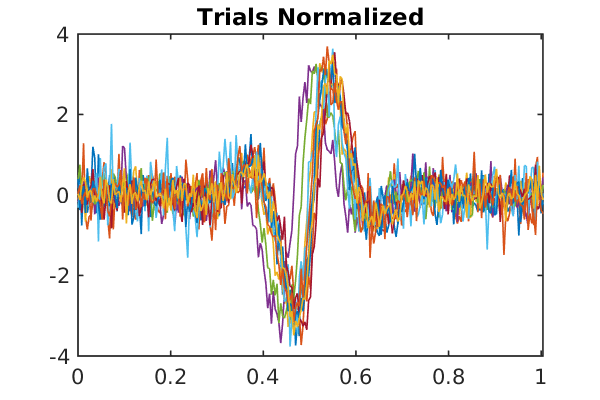

In [6]:
figure;
plot(time_axis,squeeze(x(1,:,:)));
xlim([time_axis(1), time_axis(end)]);
title('Trials Normalized');

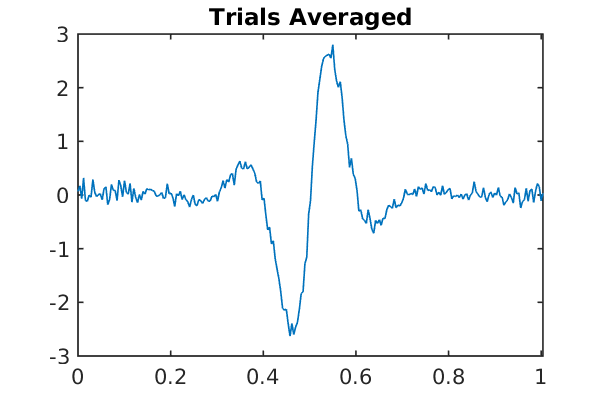

In [7]:
% take the average of all trials
x_avg = mean(x,3);

figure;
plot(time_axis,x_avg(1,:));
xlim([time_axis(1), time_axis(end)]);
title('Trials Averaged');

# Estimate the Reflection coefficients 

In [8]:
plot_options = {'ch1',2,'ch2',2};

## Multi-channel multi-trial QRDLSL1 with 10 trials

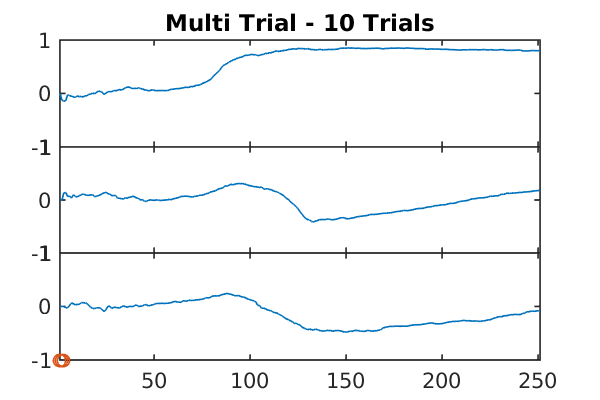

In [9]:
order_est = 3;
verbosity = 0;

lambda = 0.99;
filter = MCMTQRDLSL1(ntrials,nchannels,order_est,lambda);
trace = LatticeTrace(filter,'fields',{'Kf'});

% run the filter
figure;
plot_options_cust = [plot_options {'title','Multi Trial - 10 Trials'}];
trace.run(x,'verbosity',verbosity,'mode','plot',...
    'plot_options',plot_options_cust);

## Multi-channel multi-trial QRDLSL1 with 2 trials

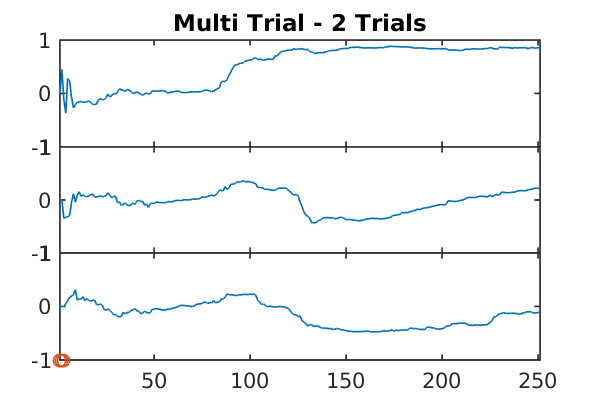

In [10]:
lambda = 0.99;
filter = MCMTQRDLSL1(2,nchannels,order_est,lambda);
trace = LatticeTrace(filter,'fields',{'Kf'});

% run the filter
figure;
plot_options_cust = [plot_options {'title','Multi Trial - 2 Trials'}];
trace.run(x(:,:,1:2),'verbosity',verbosity,'mode','plot',...
    'plot_options',plot_options_cust);

## Multi-channel QRDLSL on single trial

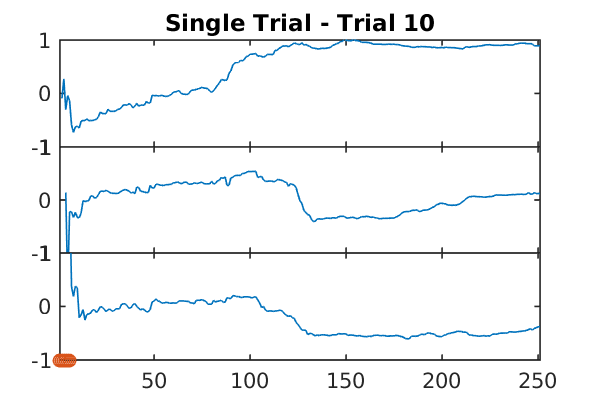

In [11]:
filter = MQRDLSL1(nchannels,order_est,lambda);
% filter = MQRDLSL2(nchannels,order_est,lambda);
trace = LatticeTrace(filter,'fields',{'Kf'});

% run the filter
figure;
plot_options_cust = [plot_options {'title',sprintf('Single Trial - Trial %d',i)}];
trace.run(x(:,:,1),'verbosity',verbosity,'mode','plot',...
    'plot_options',plot_options_cust);

## Multi-channel QRDLSL on averaged signal

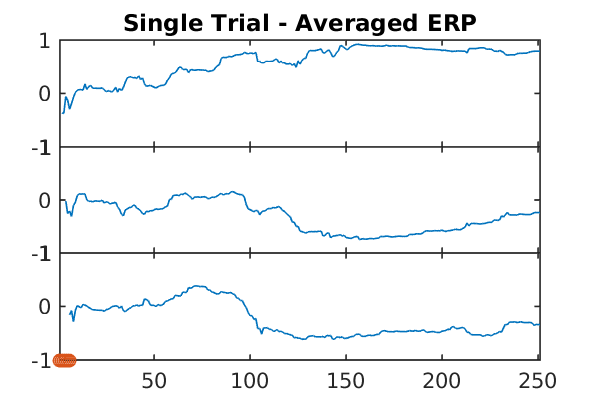

In [12]:
filter = MQRDLSL1(nchannels,order_est,lambda);
% filter = MQRDLSL2(nchannels,order_est,lambda);
trace = LatticeTrace(filter,'fields',{'Kf'});

% run the filter
figure;
plot_options_cust = [plot_options {'title','Single Trial - Averaged ERP'}];
trace.run(x_avg,'verbosity',verbosity,'mode','plot',...
    'plot_options',plot_options_cust);